# Characterizing Distributions of Generated Molecules

## Configuration

In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set gpu

cwd = os.getcwd()
print('Working directory:', cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
Working directory: /home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [2]:
import numpy as np
import pandas as pd

from rdkit import Chem
import useful_rdkit_utils as uru

import pickle

from molscore import MolScore
from moleval.metrics.metrics import GetMetrics

from fcd import get_fcd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
#Seaborn settings for visualizations

rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'YlOrRd'

sns.set(rc=rc)
pd.set_option('display.max_columns',35)
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# Set pandas display options to improve readability

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

In [5]:
fragments = []

f = open("data/fragments.smi", "r")

for i in range(1, 51):
    mol = f.readline()
    fragments.append(mol[:-1])

In [6]:
models = ['reinvent', 'crem', 'coati', 'safe']

## Generating Data

In [7]:
# %%capture

# reinvent_distributions, crem_distributions, coati_distributions, safe_distributions = [], [], [], []

# for fragment in fragments:
#     for model in models:

#         DF_FILEPATH = f'data/{model}_dataframe.csv'

#         arg1 = '--model'
#         arg2 = '--input_frag'
#         arg3 = '--sample'

#         args = ['python3', 'generate_analogs.py',
#                 arg1, model,
#                 arg2, fragment,
#                 arg3, '200']

#         # Change directory to generate analogs with python script
#         %cd ..

#         subprocess.run(args,
#                     stdout=subprocess.DEVNULL,
#                     stderr=subprocess.STDOUT)
                
#         # Change directory back to that of the current notebook
#         %cd experiments

#         df = pd.read_csv(DF_FILEPATH, index_col=0)

#         df['Model'] = model

#         if model == 'reinvent':
#             reinvent_distributions.append(df)
#         elif model == 'crem':
#             crem_distributions.append(df)
#         elif model == 'coati':
#             coati_distributions.append(df)
#         elif model == 'safe':
#             safe_distributions.append(df)

In [8]:
# data = {'reinvent' : reinvent_distributions,
#         'crem' : crem_distributions,
#         'coati' : coati_distributions,
#         'safe' : safe_distributions}

In [9]:
# with open('lists.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [10]:
with open('lists.pkl', 'rb') as file:
    data = pickle.load(file)

In [11]:
reinvent_distributions = data['reinvent']
crem_distributions = data['crem']
coati_distributions = data['coati']
safe_distributions = data['safe']

In [12]:
for d in data:

    for i, df in enumerate(data[d]):

        df['Input Fragment'] = fragments[i]

## Preprocessing

### Filtering Odd Rings

In [13]:
def remove_odd_rings(df):

    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

    odd_rings = df['min_freq'] < 100

    df['Odd rings'] = ~ odd_rings

    df = df[df['Odd rings']].drop(columns=['Odd rings'])
    
    return df.loc[:, ['SMILES', 'Model', 'Input Fragment']]

In [14]:
'''
Removes distributions with zero molecules

Removes invalid SMILES strings

Removes odd ring systems from distributions
'''

for d in data:
    
    for i, df in enumerate(data[d]):

        if len(df['SMILES']) == 0:
            data[d].pop(i)

        else:

            smiles_list = df['SMILES'].to_list()

            valid_smiles = []
            invalid_smiles = []

            for smiles in smiles_list:
                
                try:
                    molecule = Chem.MolFromSmiles(smiles, sanitize=True)
                    if molecule is not None:
                        valid_smiles.append(True)
                    else:
                        valid_smiles.append(False)
                except Exception as e:
                    invalid_smiles.append(smiles)

            df = remove_odd_rings(df)

            data[d][i] = df

            if df.empty: data[d].pop(i)

        # if df.empty:
        #     data[d].pop(i)
        #     print(i)

## Computing Distribution Metrics

In [15]:
metrics_df = pd.DataFrame()

In [16]:
data['safe'].pop(8)
data['safe'].pop(7);

In [17]:
%%capture

for d in data:
    
    for df in data[d]:
        
        smiles = df['SMILES'].to_list()

        fragment = df['Input Fragment'].to_list()[0]

        MetricEngine = GetMetrics(
            n_jobs=1,
            device='cuda:0',
            batch_size=512,
            run_fcd=False,
            train=fragment
        )
        metrics = MetricEngine.calculate(
            smiles,
            calc_valid=True,
            calc_unique=True,
            unique_k=10000,
            se_k=1000,
            sp_k=1000,
            properties=True,
        )

        # Compute FreChet Distance

        frag_mol = Chem.MolFromSmiles(fragment)
        canon_frag = Chem.MolToSmiles(frag_mol)

        mols = [Chem.MolFromSmiles(smi) for smi in smiles]
        canon_smiles = [Chem.MolToSmiles(mol) for mol in mols]

        fcd = get_fcd(canon_frag, canon_smiles)

        temp_df = pd.DataFrame(data=metrics, index=[0])

        temp_df['Model'] = d

        temp_df['FCD'] = fcd

        metrics_df = pd.concat((metrics_df, temp_df))

bloom_read: loaded bloom filter size=838776913 bits, MB=99.989998, k=62


## Exploratory Data Analysis

### Preliminary Statistics

In [ ]:
metrics_df.head()

,#,Validity,# valid,Uniqueness,# valid & unique,Novelty,# novel,IntDiv1,IntDiv2,SEDiv,SPDiv,# scaffolds,ScaffDiv,ScaffUniqueness,FG,RS,Filters,Purchasable_ZINC20,Model,FCD
0,102,1.00,102,0.93,95,1.00,95,0.79,0.75,0.27,0.91,39,0.74,0.41,0.08,0.31,0.49,0.32,reinvent,34.08
0,200,1.00,200,0.94,188,1.00,188,0.74,0.72,0.16,0.89,26,0.72,0.14,0.08,0.09,0.53,0.19,reinvent,48.58
0,199,1.00,199,0.94,188,1.00,188,0.77,0.74,0.21,0.90,17,0.59,0.09,0.09,0.05,0.59,0.44,reinvent,38.41
0,199,1.00,199,0.89,178,1.00,178,0.66,0.64,0.08,0.79,23,0.60,0.13,0.11,0.08,0.84,0.36,reinvent,53.09
0,200,1.00,200,0.96,192,1.00,192,0.73,0.71,0.17,0.88,22,0.62,0.11,0.09,0.03,0.57,0.40,reinvent,34.56


In [ ]:
metrics_df[['Model', 'Uniqueness', 'Validity', 'Novelty', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', 'ScaffDiv', 'FG', 'RS', 'Purchasable_ZINC20', 'FCD']].groupby("Model").mean()


,Uniqueness,Validity,Novelty,IntDiv1,IntDiv2,SEDiv,SPDiv,ScaffDiv,FG,RS,Purchasable_ZINC20,FCD
Model,,,,,,,,,,,,
coati,1.00,1.00,1.00,0.65,0.63,0.21,0.88,0.69,0.19,0.16,0.09,41.18
crem,1.00,1.00,1.00,0.78,0.76,0.38,0.91,0.75,0.22,0.18,0.35,44.42
reinvent,0.92,1.00,1.00,0.67,0.65,0.11,0.78,0.63,0.08,0.07,0.22,45.78
safe,0.81,1.00,1.00,0.59,0.58,0.07,0.73,0.62,0.09,0.09,0.00,38.30


In [ ]:
metrics_df[['Model', 'Uniqueness', 'Validity', 'Novelty', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', 'ScaffDiv', 'FG', 'RS', 'Purchasable_ZINC20', 'FCD']].groupby("Model").std()

,Uniqueness,Validity,Novelty,IntDiv1,IntDiv2,SEDiv,SPDiv,ScaffDiv,FG,RS,Purchasable_ZINC20,FCD
Model,,,,,,,,,,,,
coati,0.00,0.00,0.00,0.07,0.07,0.11,0.06,0.08,0.11,0.11,0.07,6.16
crem,0.00,0.00,0.00,0.09,0.09,0.25,0.11,0.09,0.06,0.10,0.17,5.86
reinvent,0.02,0.00,0.00,0.06,0.05,0.06,0.08,0.07,0.02,0.05,0.15,8.05
safe,0.19,0.00,0.00,0.08,0.07,0.06,0.11,0.08,0.04,0.04,0.00,6.13


#### Observations:

 * Uniqueness: Interestingly, COATI and CReM generate distributions which have a uniqueness score of 1, whereas REINVENT and SAFE seem to be generating more duplicates (with SAFE generating the most). It is also interesting to note that the standard deviation of uniqueness for SAFE distributions is much higher than the rest, indicating a high sensitivity for this metric to the input fragment.

 * Diversity: CReM tends to generate the most diverse distributions, whereas SAFE seems to generate the least diverse distributions. All models seem to have fairly consistent diversity metrics; however, it is interesting to note the high standard deviation in sphere exclusion diversity score for CReM.

 * Purchasability: Interestingly, CReM and REINVENT tend to generate purchasable molecules at a higher rate than the rest of the models, while SAFE has an average purchasability rate of 0 across all distributions.

### Missing Values

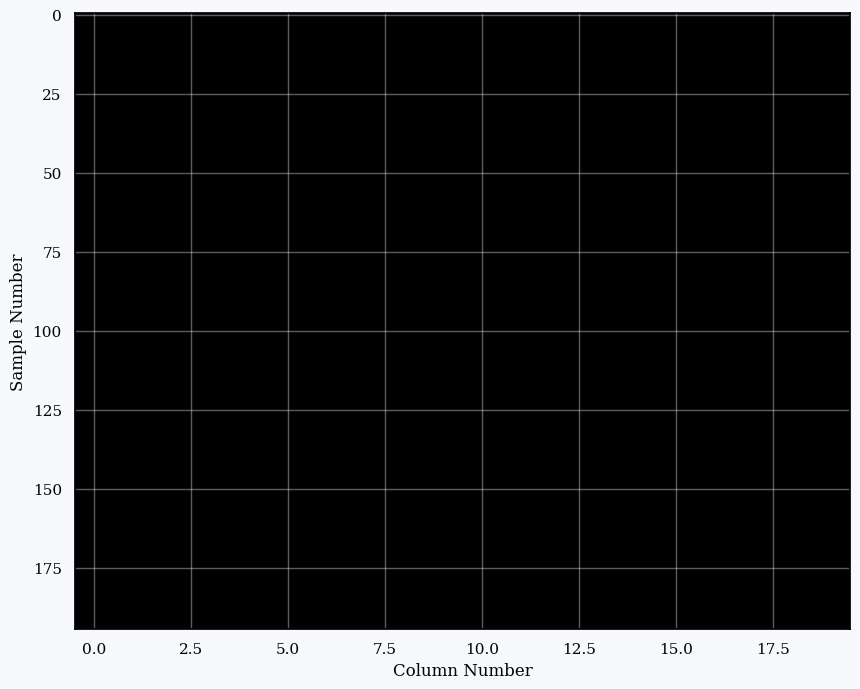

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(metrics_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

It seems like there are no missing values in the dataset.

### Visualizing the distributions (of distributions)

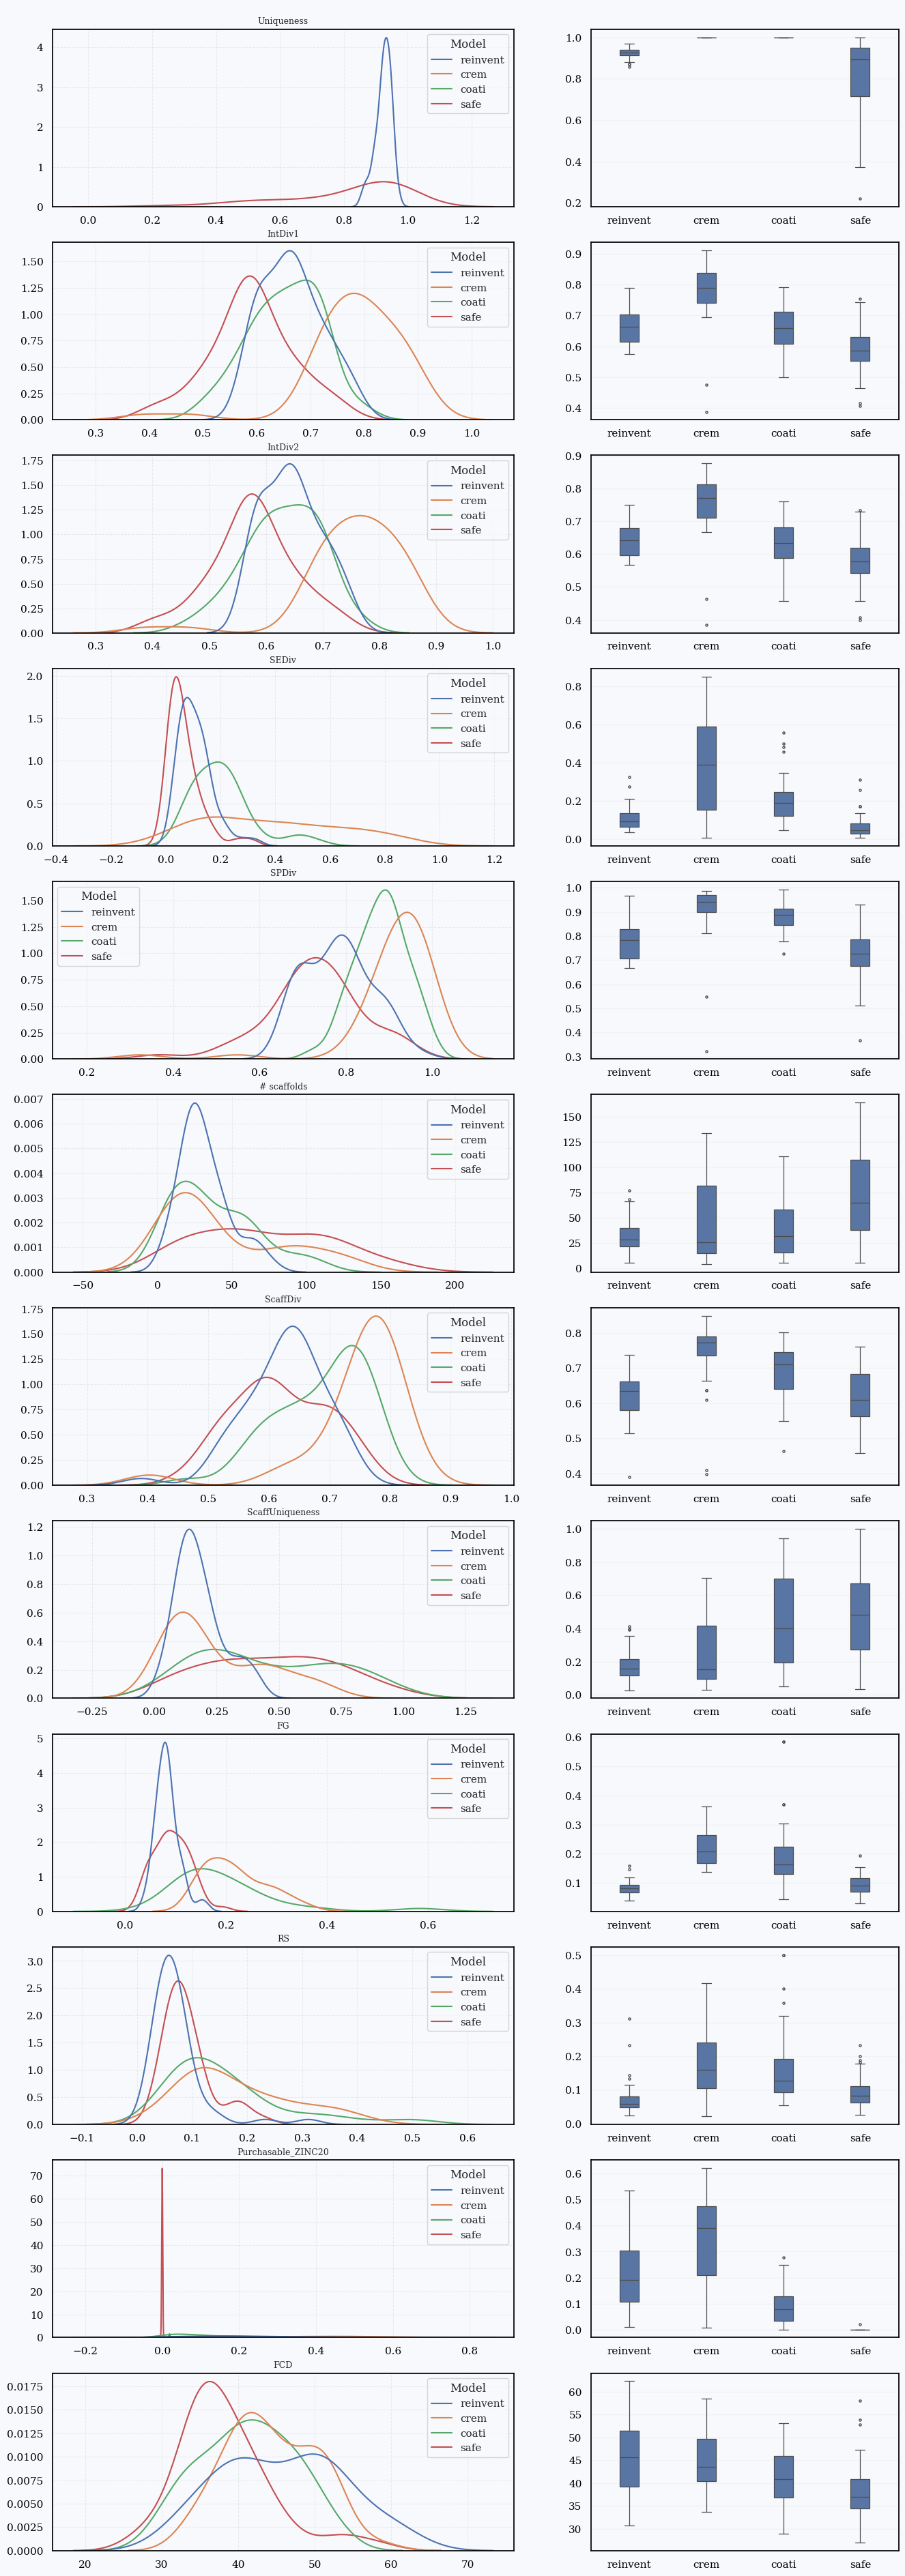

In [ ]:
cols = ['Uniqueness', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', '# scaffolds', 'ScaffDiv', 'ScaffUniqueness', 'FG', 'RS', 'Purchasable_ZINC20', 'FCD']

fig, axs = plt.subplots(nrows=len(cols),
                        ncols=3,
                        figsize=(16, len(cols)*4),
                        gridspec_kw={'width_ratios' : [0.5, 0.3, 0.2]})

for i, col in enumerate(cols):

    ax = axs[i, 0]

    sns.kdeplot(data=metrics_df[[col,'Model']],
                x=col,
                hue='Model',
                warn_singular=False,
                ax=ax)
    
    ax.set_title(f"\n{col}", fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')
    
    ax = axs[i, 1]

    sns.boxplot(data=metrics_df,
                x = 'Model',
                y=col,
                ax=ax,
                width=0.25,
                linewidth=0.90,
                fliersize=2.25)
    
    ax.set(xlabel = '', ylabel = '')

    ax = axs[i, 2]
    pc = sp.posthoc_mannwhitney(metrics_df,val_col=cols,group_col="Model",p_adjust='holm')
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    _ = sp.sign_plot(pc, **heatmap_args)

It seems like the models can be consistently differentiated.

### Assessing correlation

In [ ]:
y = metrics_df['Model'].to_numpy().reshape(-1, 1)

In [ ]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [ ]:
X = metrics_df[cols]

X['Model'] = ord.squeeze()

In [ ]:
# Computes feature correlation
corr = X.corr(method="pearson")

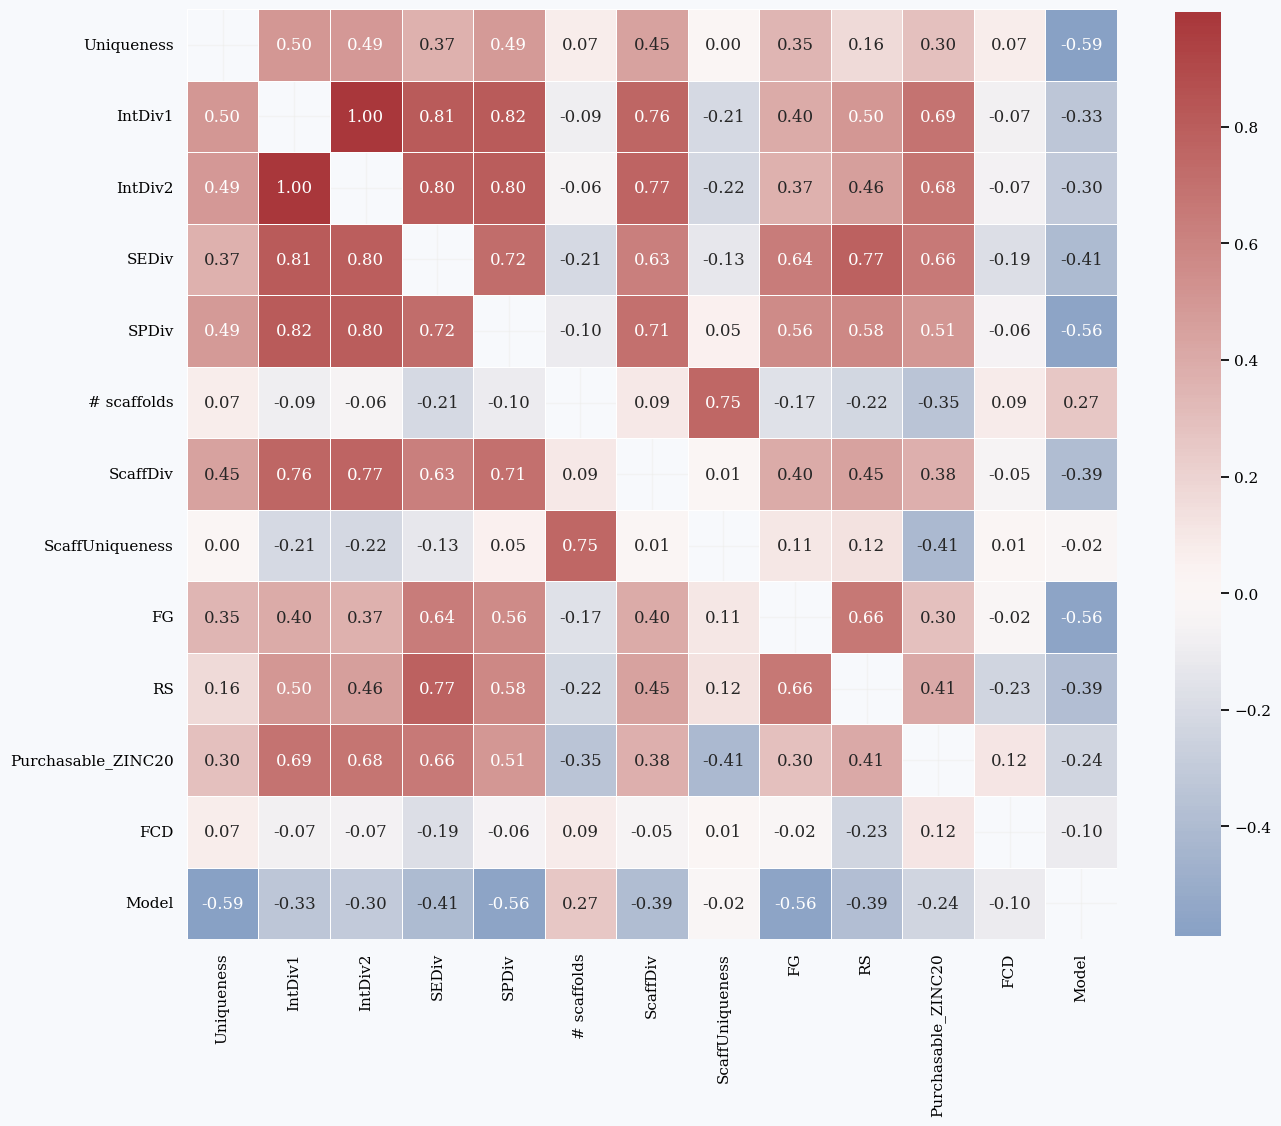

In [ ]:
# Create labels for the correlation matrix
labels = np.where(np.abs(corr)>0.75, "S",
                  np.where(np.abs(corr)>0.5, "M",
                           np.where(np.abs(corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=np.eye(len(corr)), square=True,
            center=0, annot=True, fmt='.2f', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

It's somewhat unsurprising that a lot of the variables are highly correlated, considering the fact that many of them measure similar quantities. Some nontrivial relationships:

 * High correlation between purchasability and internal diversity
 * High correlation between functional group and ring system diversity